# Density matrices in Fock space

In this notebook we introduce our new feature: __density matrices__ in __fock space__ - and explore their application. Fock space is a mathematical framework to describe the quantum states of a system with variable number of particles, __photons__ in our case. Note that this space is much larger than the computational/logical space. Fock space is native to _Perceval_ and hence these matrices can be indispensable for linear optic computation.

The difference in the basis is demonstrated in the following example of 1-qubit X gate flipping the state of 1 input photon. In logical space, the basic states of the system will be $|0\rangle$, and $|1\rangle$. The linear optical circuit implementation for this gate involves a 2 mode circuit with basic states $|00\rangle$, $|10\rangle$, $|01\rangle$, and, $|11\rangle$.

We will use a simple _Bell state_ generation and measurements to present the features of our density matrices.


In [99]:
import perceval as pcvl
from perceval.components import BS, Source, PS, Circuit, catalog, PERM
import numpy as np
from perceval.utils import BasicState, DensityMatrix, StateGenerator, Encoding
from perceval import Simulator
from perceval.backends import SLOSBackend


Let's first look at a simple 2 mode beam splitter for functional use of density matrices

In [162]:
circuit = BS.H()

sim = Simulator(SLOSBackend())
sim.set_circuit(circuit)

output_state = sim.evolve(BasicState([1, 1]))
print(output_state)

sqrt(2)/2*|2,0>-sqrt(2)/2*|0,2>


Any svd can be converted to a Density matrix

0.50+0.00j*|2,0><2,0|+-0.50+0.00j*|0,2><2,0|+-0.50+0.00j*|2,0><0,2|+0.50+0.00j*|0,2><0,2|


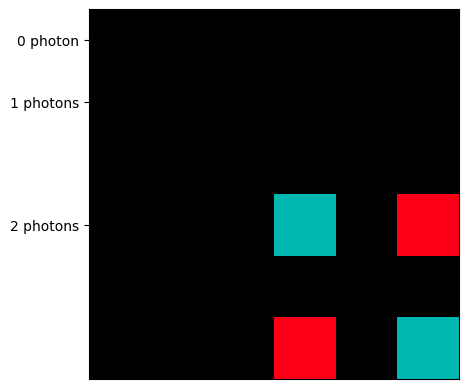

In [163]:
output_density_matrix = DensityMatrix.from_svd(output_state)
print(output_density_matrix)
pcvl.pdisplay(output_density_matrix)

However, we could begin with a Density matrix and evolve it instead of evolving the statevector distribution to get identical results

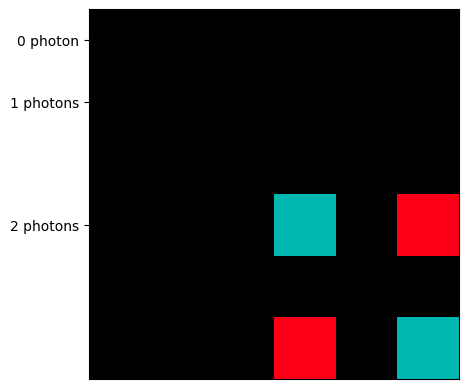

In [172]:
source = Source()
input_density_matrix = DensityMatrix.from_svd(source.generate_distribution(BasicState([1, 1])))

output_density_matrix = sim.evolve_density_matrix(input_density_matrix)
pcvl.pdisplay(output_density_matrix)

Our density matrices also support adding loss of photons.

The example here shows a source with emission probability of 0.6 or a loss of a photon from each mode of the perfect density matrix with a probability of 0.4

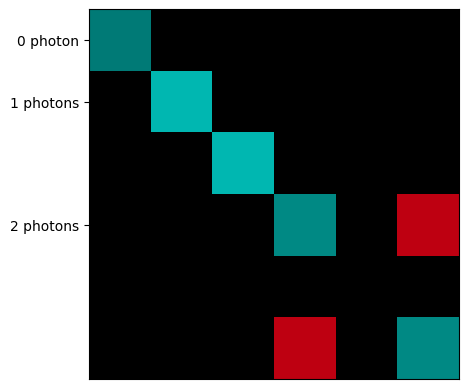

In [173]:
input_density_matrix.apply_loss([0, 1], 0.4)
output_density_matrix = sim.evolve_density_matrix(input_density_matrix)
pcvl.pdisplay(output_density_matrix)

# todo : add expectation value code

## Bell State generation and measurements

In [108]:
sg = StateGenerator(encoding=Encoding.DUAL_RAIL)

In [109]:
bell_state = sg.bell_state('phi+')
print(bell_state)

sqrt(2)/2*|0,1,0,1>+sqrt(2)/2*|1,0,1,0>


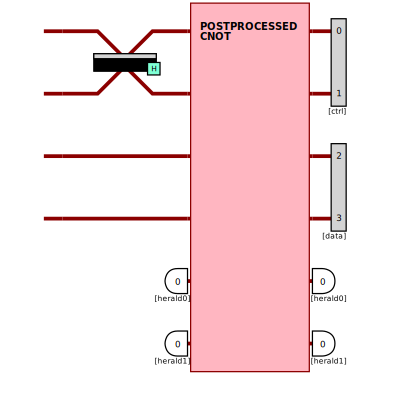

In [139]:
cnot = catalog['postprocessed cnot'].build_processor()
bell_p = cnot.copy()
bell_p.clear_input_and_circuit(cnot.m)  # Clear processor content but keep its size
bell_p.add(0, BS.H())
bell_p.add(0, cnot)
pcvl.pdisplay(bell_p)

In [155]:
input_state = BasicState([1, 0, 1, 0])
bell_p.with_input(input_state)

In [158]:
from perceval.algorithm import Sampler
sampler = Sampler(bell_p)
probs = sampler.probs()
output_distribution = probs["results"]
print(output_distribution)

{
  |1,0,1,0>: 0.5
  |0,1,0,1>: 0.5
}


# cnot circ to simulator - to use in density matrix evolve

In [159]:
cnot_circ = catalog['postprocessed cnot'].build_circuit()

bell_circ = Circuit(m=6)
bell_circ.add(0, BS.H())
bell_circ.add(0, cnot_circ)

bell_sim = Simulator(SLOSBackend())
bell_sim.set_circuit(bell_circ)
bell_sim.set_selection(heralds=cnot.heralds, postselect=cnot.post_select_fn)
output_state = bell_sim.evolve(BasicState([1,0,1,0,0,0]))
print(output_state)

sqrt(2)/2*|1,0,1,0,0,0>+sqrt(2)/2*|0,1,0,1,0,0>


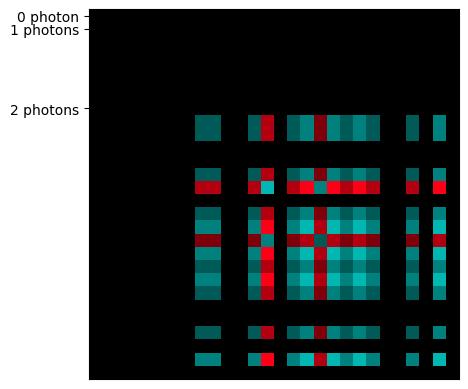

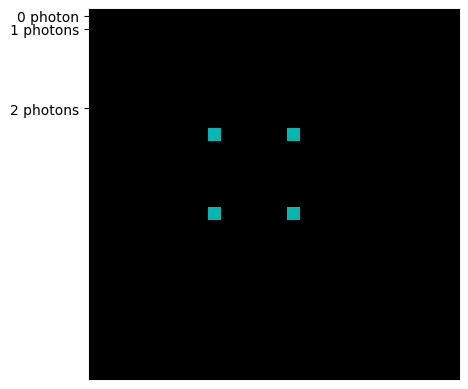

In [160]:
bell_out_dm = bell_sim.evolve_density_matrix(DensityMatrix.from_svd(BasicState([1,0,1,0,0,0])))
pcvl.pdisplay(bell_out_dm)

pcvl.pdisplay(DensityMatrix.from_svd(output_state))

In [161]:
print(bell_out_dm)

0.06+0.00j*|1,1,0,0,0,0><1,1,0,0,0,0|+0.06+0.00j*|1,0,1,0,0,0><1,1,0,0,0,0|+0.06+0.00j*|1,0,0,0,0,1><1,1,0,0,0,0|+-0.08+0.00j*|0,2,0,0,0,0><1,1,0,0,0,0|+0.06+0.00j*|0,1,0,1,0,0><1,1,0,0,0,0|+0.08+0.00j*|0,1,0,0,1,0><1,1,0,0,0,0|+-0.06+0.00j*|0,1,0,0,0,1><1,1,0,0,0,0|+0.08+0.00j*|0,0,2,0,0,0><1,1,0,0,0,0|+0.06+0.00j*|0,0,1,1,0,0><1,1,0,0,0,0|+0.08+0.00j*|0,0,1,0,1,0><1,1,0,0,0,0|+0.06+0.00j*|0,0,1,0,0,1><1,1,0,0,0,0|+0.06+0.00j*|0,0,0,1,0,1><1,1,0,0,0,0|+0.08+0.00j*|0,0,0,0,1,1><1,1,0,0,0,0|+0.06+0.00j*|1,1,0,0,0,0><1,0,1,0,0,0|+0.06+0.00j*|1,0,1,0,0,0><1,0,1,0,0,0|+0.06+0.00j*|1,0,0,0,0,1><1,0,1,0,0,0|+-0.08+0.00j*|0,2,0,0,0,0><1,0,1,0,0,0|+0.06+0.00j*|0,1,0,1,0,0><1,0,1,0,0,0|+0.08+0.00j*|0,1,0,0,1,0><1,0,1,0,0,0|+-0.06+0.00j*|0,1,0,0,0,1><1,0,1,0,0,0|+0.08+0.00j*|0,0,2,0,0,0><1,0,1,0,0,0|+0.06+0.00j*|0,0,1,1,0,0><1,0,1,0,0,0|+0.08+0.00j*|0,0,1,0,1,0><1,0,1,0,0,0|+0.06+0.00j*|0,0,1,0,0,1><1,0,1,0,0,0|+0.06+0.00j*|0,0,0,1,0,1><1,0,1,0,0,0|+0.08+0.00j*|0,0,0,0,1,1><1,0,1,0,0,0|+0.06+0.0